In [ ]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString
import os

def parse_mgeom(value):
    """Parse LINESTRING format into a LineString object."""
    try:
        if value.startswith("LINESTRING"):
            coords = value.replace("LINESTRING(", "").replace(")", "").split(",")
            coords = [(float(coord.split()[0]), float(coord.split()[1])) for coord in coords]
            return LineString(coords)
        return None
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

def visualize_first_15_routes(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    # Load and parse geometries
    df = pd.read_csv(file_path)
    df['geometry'] = df['mgeom'].apply(parse_mgeom)
    df = df.dropna(subset=['geometry'])
    if df.empty:
        print("No valid geometries found.")
        return

    # Initialize boundaries
    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first = True
    num_routes = min(15, len(df))

    # Calculate boundaries based on route data
    for i, geometry in enumerate(df['geometry'].head(num_routes)):
        x, y = geometry.xy
        for lon, lat in zip(x, y):
            current_x_max, current_y_max, current_x_min, current_y_min, is_first = calculate_boundaries(
                current_x_max, current_y_max, current_x_min, current_y_min, is_first, lon, lat
            )

    # Adjust boundaries with padding for the map view
    if is_first:
        current_x_min, current_x_max = -8.7, -8.5  
        current_y_min, current_y_max = 41.1, 41.3
    else:
        x_padding = (current_x_max - current_x_min) * 0.05
        y_padding = (current_y_max - current_y_min) * 0.05
        current_x_min -= x_padding
        current_x_max += x_padding
        current_y_min -= y_padding
        current_y_max += y_padding

    # Create a folium map centered on the calculated boundaries
    f = folium.Figure(width=1500, height=1000)
    fmap = folium.Map(location=[(current_y_max + current_y_min) / 2, (current_x_max + current_x_min) / 2],
                      zoom_start=13, max_bounds=True)
    fmap.add_to(f)
    fmap.fit_bounds([[current_y_min, current_x_min], [current_y_max, current_x_max]])

    # Save the map as an HTML file
    output_dir = 'data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'Map of Porto.html')
    fmap.save(output_path)

    print(f"Interactive map without markers saved to {output_path}")

# Run the function with the specified file path
visualize_first_15_routes("data/map_matching_1500.csv")


Error parsing geometry: list index out of range
Error parsing geometry: IllegalArgumentException: point array must contain 0 or >1 elements

Error parsing geometry: IllegalArgumentException: point array must contain 0 or >1 elements

Interactive map without markers saved to data\Map of Porto.html


xMin: -8.689086, yMin: 41.134158, xMax: -8.562348, yMax: 41.180517


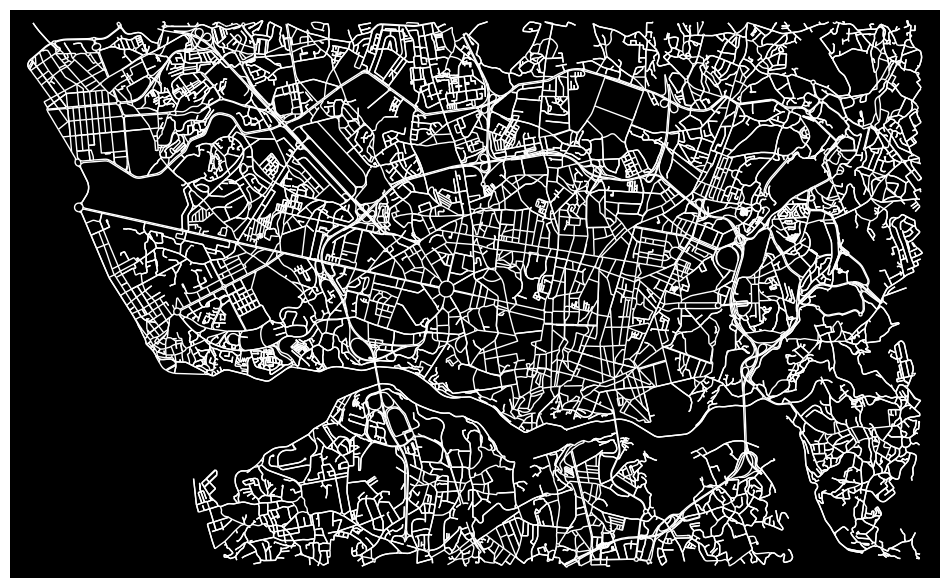

Map image saved to data\Map_of_Porto.png


In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import os

# Load the first 15 rows of the dataset to calculate boundaries
df_15 = pd.read_csv('data/train-1500.csv', nrows=15)

# Function to calculate boundaries from trajectories
def calculate_boundaries(df):
    x_max = y_max = x_min = y_min = None
    is_first = True
    for polyline in df['POLYLINE']:
        polyline = polyline[2:-2]
        if len(polyline) > 2:
            for coordinate in polyline.split('],['):
                longitude, latitude = map(float, coordinate.strip().split(','))
                if is_first:
                    x_min = x_max = longitude
                    y_min = y_max = latitude
                    is_first = False
                else:
                    x_max = max(x_max, longitude)
                    x_min = min(x_min, longitude)
                    y_max = max(y_max, latitude)
                    y_min = min(y_min, latitude)
    return x_min, x_max, y_min, y_max

# Calculate boundaries
x_min, x_max, y_min, y_max = calculate_boundaries(df_15)
print(f'xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')

# Create the road network within the calculated boundaries
buffer_distance = 0.01
boundaries = (x_min - buffer_distance, x_max + buffer_distance, y_min - buffer_distance, y_max + buffer_distance)
lower_left_x, upper_right_x, lower_left_y, upper_right_y = boundaries

boundary_polygon = Polygon([
    (lower_left_x, lower_left_y), 
    (upper_right_x, lower_left_y), 
    (upper_right_x, upper_right_y), 
    (lower_left_x, upper_right_y)
])

# Generate the road network within the specified polygon
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

# Plot only the road network without any trajectory lines or markers
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(12, 12), bgcolor='black', edge_color='white', node_color='black', node_size=0)

# Save the map as an image file
output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'Map_of_Porto.png')
plt.savefig(output_path, format='png', dpi=300)
plt.show()

print(f"Map image saved to {output_path}")
